In [1]:
#Choosing training/validation for Y3

#50/50 : start with 150 deg^2, 250 deg^2, 350 deg^2 – converge on limit for size
#*Random selection of parts of 624deg^2 to show invariance or not
#**reserve part of overlap region for science**

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

%load_ext autoreload
%autoreload 2

#for only galaxies: EXTENDED_CLASS_MASH_SOF = 3 apply this cut (this is the same as Y1 MODEST cut)

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
sys.path.append('../')
from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io

In [3]:
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3


In [4]:
from xdgmm import XDGMM as XDGMM_Holoien

In [5]:
def _FindOptimalN_with_err( N, Xdata, Xcov, pickleFileName = None, suffix = None):
    #from sklearn.mixture import GMM
    #data, _ = mixing_color(data, suffix = suffix)
    @pickle_results( pickleFileName )
    def compute_GMM( N, covariance_type='full', n_iter=1000):
        models = [None for n in N]
        for i in range(len(N)):
            sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                             .format(i * 1./len(N) * 100.))
            sys.stdout.flush()
            models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter,
                            covariance_type=covariance_type)
            models[i].fit(Xdata, Xcov)
        return models
    
    models = compute_GMM(N)
    AIC = [m.aic(Xdata) for m in models]
    BIC = [m.bic(Xdata) for m in models]
    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                     .format(100))
    print("\nbest fit converged:", gmm_best.converged_, end=' ')
    print(" n_components =  %i" % N[i_best])
    return N[i_best], AIC, BIC

def XDnew_fitting_X( X = None, Xcov=None, 
        FileName = None, 
        #init_params = None, 
        #suffix='', 
        #mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        #filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, method='Bovy', verbose=False ):

    

    try: 
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj
    except FileNotFoundError: pass
    
    if X is None:
        # calling pre-computed model
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj

    else: 
        if n_cl == None : 
            param_range=np.arange(2, 50, 2)
            optimal_n_comp,_,_= _FindOptimalN_with_err( param_range, X, Xcov, 
            pickleFileName = FileName+'.n_cluster' , suffix = '')
            
            #xdgmm_test = XDGMM_Holoien( n_iter=n_iter, tol=tol, method=method )
            ## Define the range of component numbers, and get ready to compute the BIC for each one:
            #param_range = np.arange(2, 50, 2)
            ## Loop over component numbers, fitting XDGMM model and computing the BIC:
            #bic, optimal_n_comp, lowest_bic = xdgmm_test.bic_test(X, Xcov, param_range)
            ##n_cl = optimal_n_comp[np.argmin(bic)]
        else: optimal_n_comp = n_cl

        #import time
        # fitting
        #initiated class
        xdgmm_obj = XDGMM_Holoien( n_components=optimal_n_comp, n_iter=n_iter, tol=tol, method=method )
        #xdgmm.n_components = optimal_n_comp
        print ('n_components=', optimal_n_comp)
        print ('fitting started. This will take for a while.')
#        t1 = time.time()
        xdgmm_obj = xdgmm_obj.fit(X, Xcov)
        #t2 = time.time()
        print ('fitting finished')
        
        #t3 = time.time()
        print ('saving xdgmm object to.. ', FileName)
        xdgmm_obj.save_model(FileName)
        print ('file saved')
        #print ('saving obj. time:', (t3-t2)%60,'s')
        
        #t4 = time.time()
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        #print ('loading obj. time:', (t4-t3)%60,'s')
#        t2 = time.time()
#        print ('elapsed time:', (t2-t1)/60.0,'s')
        return xdgmm_obj

In [6]:
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASSY3/code_py3


In [7]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [8]:
# call required functions from modules 

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000125.fits
Y3_GOLD_2_0_STRIPE82_000136.fits
Y3_GOLD_2_0_STRIPE82_000040.fits
Y3_GOLD_2_0_STRIPE82_000015.fits
Y3_GOLD_2_0_STRIPE82_000086.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000108.fits
Y3_GOLD_2_0_STRIPE82_000079.fits
Y3_GOLD_2_0_STRIPE82_000076.fits
Y3_GOLD_2_0_STRIPE82_000057.fits
Y3_GOLD_2_0_STRIPE82_000111.fits
Y3_GOLD_2_0_STRIPE82_000084.fits
Y3_GOLD_2_0_STRIPE82_000088.fits
Y3_GOLD_2_0_STRIPE82_000049.fits
Y3_GOLD_2_0_STRIPE82_000063.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000077.fits
Y3_GOLD_2_0_STRIPE82_000042.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000115.fits
Y3_GOLD_2_0_STRIPE82_000028.fits
Y3_GOLD_2_0_STRIPE82_000140.fits
Y3_GOLD_2_0_STRIPE82_000060.fits
Y3_GOLD_2_0_STRIPE82_000089.fits
Y3_GOLD_2_0_STRIPE82_000143.fits
Y3_GOLD_2_0_STRIPE82_000012.fits
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000137.fits
Y3_GOLD_2_0_STRIPE82_

In [9]:
#this CMASS used for Y1, and Y3 now:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

#mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
#mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
#gold_st82_train = gold_st82[mask]
gold_st82_train = gold_st82

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

print(('num of cmass in des side', clean_cmass_data_des_train.size, '({:0.0f}%)'.format(clean_cmass_data_des_train.size*1./cmass.size*100.)))

gold_st82 = None
train_sample = None

healConfig={'out_nside':64, 'nest':True}

train_sample = HealPixifyCatalogs(catalog=clean_cmass_data_des_train, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82_train, healConfig=healConfig, ratag='RA', dectag = 'DEC')

#numbers slightly off: odd 6325  even 6314 -- from Su
#total healpix number is larger --- proportional to area, therefore larger area --- mask is different-- masking less of region
evenmask_train = train_sample['HEALIndex']%2 == 0
evenmask = gold_st82['HEALIndex']%2 == 0

pixarea = hp.nside2pixarea( 64, degrees = True)
print('odd', np.sum(evenmask_train), ' even', np.sum(~evenmask_train))
print('area', 'odd', np.sum(evenmask_train)*pixarea, ' even', np.sum(~evenmask_train)*pixarea)
print(pixarea)

GoldMask_st82_hpix64 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')
ringhpindex = hp.nest2ring(4096, [GoldMask_st82_hpix64['HEALIndex']])
evenmask_map = ringhpindex%2 == 0 
#pixarea64 = hp.nside2pixarea( 64, degrees = True)

print('odd', np.sum(evenmask_map), ' even', np.sum(~evenmask_map))
print('area', 'odd', np.sum(evenmask_map)*pixarea, ' even', np.sum(~evenmask_map)*pixarea)
# area odd 62.36836976435403  even 62.522253926354416

GoldMask_st82_hpix64.size

train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]

# Directory doesn't exist ---- create 
# check for error: print statement 
import os
outdir = '../output/validate_NEST/'
if os.path.exists(outdir) == False:
    os.mkdir(outdir)
rootdir2 = '../output/validate_NEST/'

fitsio.write(rootdir2+'train_NEST_even.fits', train_even, clobber=True)
fitsio.write(rootdir2+'train_NEST_odd.fits', train_odd, clobber=True)

fitsio.write(rootdir2+'gold_st82_NEST_even.fits', gold_st82_even, clobber=True)
fitsio.write(rootdir2+'gold_st82_NEST_odd.fits', gold_st82_odd, clobber=True)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_even['RA'], train_even['DEC'], gold_st82_even['RA'], \
                                     gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask_even = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask_even[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask_even], gold_st82_even[~cmass_mask_even]
print('cmass_fraction even', clean_cmass_data_des_even.size *1./gold_st82_even.size)
fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size

mg1, mg2, _ = esutil.htm.HTM(10).match(train_odd['RA'], train_odd['DEC'], gold_st82_odd['RA'], \
                                     gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask_odd = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask_odd[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask_odd], gold_st82_odd[~cmass_mask_odd]
print('cmass_fraction odd', clean_cmass_data_des_odd.size *1./gold_st82_odd.size)
fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

gold_st82 = None
#train_sample = None


import numpy as np
#nocmass_random_ind = np.random.choice(np.arange(nocmass_train.size), size = int(nocmass_train.size/5))
#nocmass_random = nocmass_train[nocmass_random_ind] 

#print(nocmass_random.size)
#print(clean_cmass_data_des_train.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031
('num of cmass in des side', 60037, '(23%)')
odd 30125  even 29912
area odd 25283.721061986398  even 25104.951515556422
0.8392936452111668


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:479: RuntimeWarning: invalid value encountered in _ang2pix_nest
  return pixlib._ang2pix_nest(nside, theta, phi)


odd 2878123  even 2879653
area odd 2415590.344036099  even 2416874.463313272
cmass_fraction even 0.010454958131580117
cmass_fraction odd 0.010399225690175944


In [10]:
print(train_sample)
print(train_even)
print(train_odd)

[(113353354, 347.431533, -0.162987, 77156175, 22.44195556640625, 0.0377323180437088, 20.77531623840332, 0.010189731605350971, 19.882312774658203, 0.006808210164308548, 19.478612899780273, 0.008940847590565681, 0.0493117665978384, 0.0148981963576419, 0.0127730187025862, 0.0141965261637024, 22.264103347930693, 20.44282459513814, 19.531501237523024, 19.125969758760288, 0.021041974375218663, 0.009803868552295167, 0.009106076934764507, 0.00971933922330589, 21.702279890914994, 20.09896074367284, 19.223834222276725, 18.827232496282388, 3, 18836)
 (159501095, 357.436641, 0.008315, 76900967, 22.749671936035156, 0.044220246374607086, 20.930683135986328, 0.011372075416147709, 19.984798431396484, 0.007120335008949041, 19.485963821411133, 0.00937688909471035, 0.0448492022226086, 0.0155680467428781, 0.0135365489017809, 0.0148782417660453, 22.366665634448243, 20.530899393777798, 19.60006099008111, 19.1854142369935, 0.03331996687210553, 0.012185742891297497, 0.010669753866323932, 0.01168120075358326, 

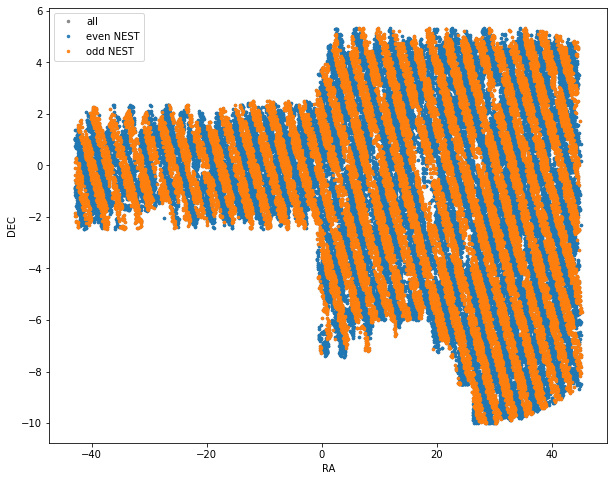

In [11]:
spatialcheck( [train_sample, train_even, train_odd], label = ['all', 'even NEST', 'odd NEST'] )

In [32]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 10000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_gold_bovyY3_fullMOFDET.xdgmm'

In [33]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(clean_cmass_data_des_even, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [34]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovyY3_fullMOFDET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  22


In [14]:
# Fitting start with Bovy's method
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')

Using precomputed results from  output/test/fitting/gauss_gold_bovyY3_full.xdgmm


In [35]:
#Next: noncmass data

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_nogold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_nogold = 15000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_nogold_bovyY3_fullMOFDET.xdgmm'

In [36]:
nocmass_random_ind = np.random.choice(np.arange(nocmass_even.size), size = int(nocmass_even.size/5))
nocmass_random = nocmass_even[nocmass_random_ind] 

print(nocmass_random.size)

570256


In [37]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_nogold, X_nogold_cov = mixing_color(nocmass_random, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [38]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_nogold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_nogold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_nogold_bovyY3_fullMOFDET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  48


In [ ]:
# Fitting start with Bovy's method
clf_nogold = XDnew_fitting_X( X_nogold, X_nogold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = n_cl_nogold, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 42
fitting started. This will take for a while.


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


In [ ]:
#testing figure 3
#gold_st82=None
#train_sample=None

In [ ]:
#training region check

#mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
#mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
#gold_st82_train = gold_st82[mask]

print(gold_st82_train.size)
gold_train_random_ind = np.random.choice(np.arange(gold_st82_train.size), size = int(gold_st82_train.size/5))
gold_train_random = gold_st82_train[gold_train_random_ind]
print(gold_train_random.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_train_random['RA'], \
                                         gold_train_random['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_train_random.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_train_random[cmass_mask_train], gold_train_random[~cmass_mask_train]

#clean_cmass_data_des = clean_cmass_data_des_train

clean_dmass_prob_train = assignCMASSProb(clean_cmass_data_des_train, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


dmass_st82_real_train = clean_dmass_prob_train # actual CMASS galaxies in train set
dmass_st82_val_train = assignCMASSProb(gold_train_random, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real_train['CMASS_PROB'], bins=pbin)

import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val_train['CMASS_PROB'], bins=pbin)

frac = N/M
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
plt.title('Training Region Check 20%')
fig.savefig('test_histo_train.pdf')

In [ ]:
# Figure 3 start: Odd/Even Method
%matplotlib inline
import matplotlib.pyplot as plt

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des_odd, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82_odd, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Validation Region Full Y3')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y3_full.pdf')